<a href="https://colab.research.google.com/github/trypanosomatics/yeast_repo_pipeline/blob/main/3D_Compounds_aligment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook overview

This notebook presents a structural comparison of selected small molecules using RDKit-based three-dimensional representations and shape alignment methods. The workflow is organized to provide a progressive visualization of the compounds, starting from individual molecular structures and moving toward pairwise and multi-compound superpositions.

First, all compounds included in the analysis are visualized individually in 2D and 3D to provide an overview of their chemical structures and conformations. These representations allow inspection of overall molecular shape, functional group distribution, and stereochemistry prior to any alignment.

Next, pairwise shape-based alignments are performed using the O3A (Optimal 3D Alignment) method, with CID12 used as the reference molecule. Each comparison is displayed using a consistent color scheme to facilitate visual interpretation and direct comparison across compounds. Shape similarity is quantified using the Tversky index, which is can be printed if needed alongside each alignment.

The Tversky index is a shape-based similarity metric that quantifies the degree of three-dimensional overlap between two molecules after alignment. In the context of RDKit shape comparisons, it is commonly used to assess how well the volume of one molecule matches that of another, with tunable asymmetry depending on which molecule is treated as the reference.

| Tversky index | Interpretation            | Description of shape overlap                          |
|---------------|---------------------------|--------------------------------------------------------|
| ≥ 0.75        | High similarity           | Strong 3D volumetric overlap; very similar global shape |
| 0.60–0.74     | Moderate–high similarity  | Substantial overlap with minor structural differences   |
| 0.45–0.59     | Moderate similarity       | Partial overlap; shared core with divergent regions     |
| < 0.45        | Low similarity            | Limited overlap; distinct overall shapes                |

Finally, all compounds are superimposed in a single 3D view while maintaining their assigned colors. This combined visualization highlights shared and divergent structural features across the full set of molecules and provides an integrated perspective on shape similarity and spatial overlap.


In [91]:
# @title Install and import

!pip install rdkit py3Dmol

import rdkit
print(rdkit.__version__)

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, rdMolAlign, rdMolTransforms
from rdkit.Chem import rdShapeAlign, rdShapeHelpers
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

import py3Dmol

import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
%matplotlib inline

%load_ext sql
%config SqlMagic.feedback=0


2025.09.3
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [92]:
# Molecules
smiles_dict = {
    "CID12" : "OC1=CC=C2C(=O)C(=COC2=C1)C1=C(Cl)C=CC=C1",
    "Cladosporin" : "C[C@H]1CCC[C@@H](O1)C[C@H]2CC3=C(C(=CC(=C3)O)O)C(=O)O2",
    "DDD508" : "C1(O)C=CC2OC(C(=O)NCC3(O)CCCCC3)=CC(=O)C=2C=1",
    "DDD489" : "N1C(N)=NC2CN(CC3C[C@@H](C(F)(F)F)CCC3)C(=O)C=2C=1C(F)(F)F",
    "DDD02049209" : "N1C(N)=NC2C[C@H](N3C(F)(F)CCCC[C@@H]3O)C(=O)C=2C=1OC",
    "DMU371" : "CC1=NC2=C(C(N)=N1)C(F)=C(F)C(NC1CCCC1)=C2F",
    "DMU759" : "CC1=NC2=C(C(N)=N1)C(F)=C(F)C(SC1CCCCC1)=C2F"
}

In [93]:
# @title Prepare molecules
# Colors
colors = {
    "CID12": "magenta",
    "Cladosporin": "cyan",
    "DDD508": "green",
    "DDD489": "orange",
    "DDD02049209": "blue",
    "DMU371" : "yellow",
    "DMU759" : "red"
}

# 3D mols
mols = {}
for name, smi in smiles_dict.items():
    mol = Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol, randomSeed=1)
    mol_c = Chem.Mol(mol)
    rdMolTransforms.CanonicalizeConformer(mol_c.GetConformer())
    mols[name] = mol_c

ref = mols["CID12"]

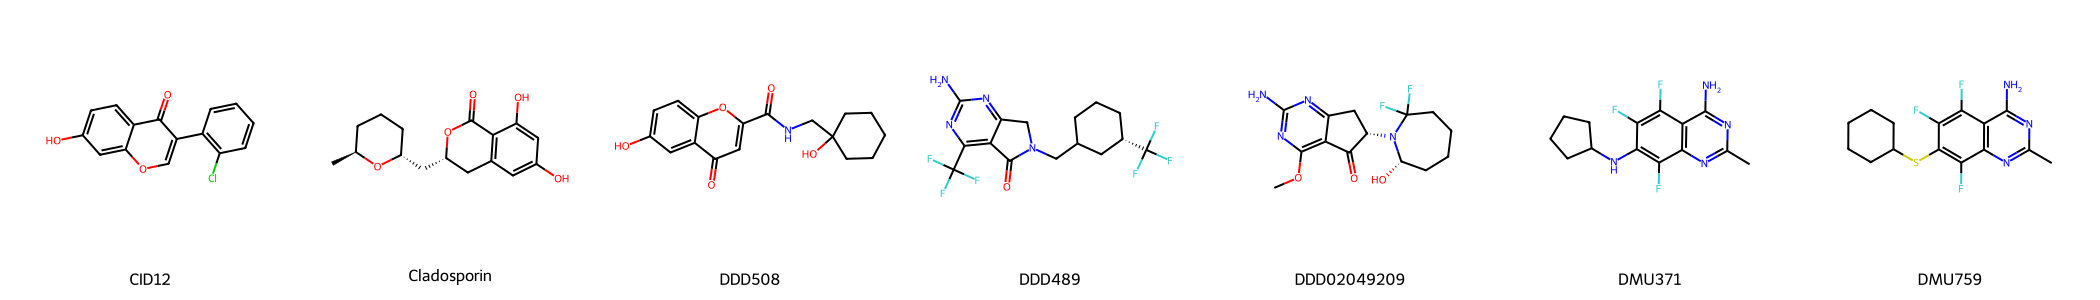

In [94]:
# @title Show molecules in 2D

mols_2d = []
legends = []

for name, smi in smiles_dict.items():
    mol = Chem.MolFromSmiles(smi)
    Chem.rdDepictor.Compute2DCoords(mol)
    mols_2d.append(mol)
    legends.append(name)

img = Draw.MolsToGridImage(
    mols_2d,
    molsPerRow=7,
    subImgSize=(300, 300),
    legends=legends
)

img

In [95]:
# @title Show molecules in 3D

for name, smi in smiles_dict.items():
    mol = Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol, randomSeed=1)
    AllChem.UFFOptimizeMolecule(mol)

    print(name)

    view = py3Dmol.view(width=400, height=300)
    view.addModel(Chem.MolToMolBlock(mol), 'sdf')
    view.setStyle({'stick': {'radius': 0.15}})
    view.zoomTo()
    view.show()


CID12


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Cladosporin


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DDD508


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DDD489


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DDD02049209


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DMU371


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DMU759


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Align

In [96]:
# @title CID 12 (magenta) vs Cladosporin (cyan)
target = "Cladosporin"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

o3a = rdMolAlign.GetO3A(mol_tar, mol_ref)
o3a.Align()
tversky_cladosporin = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_cladosporin)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.544066761652758


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [97]:
# @title CID 12 (magenta) vs DDD508 (green)

target = "DDD508"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

rdMolAlign.GetO3A(mol_tar, mol_ref).Align()
tversky_DDD508 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DDD508)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.5466117558966679


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [98]:
# @title CID 12 (magenta) vs DDD508 (orange)

target = "DDD489"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

rdMolAlign.GetO3A(mol_tar, mol_ref).Align()
tversky_DDD489 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DDD489)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.5032379004771643


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [99]:
# @title CID 12 (magenta) vs DDD02049209 (blue)
target = "DDD02049209"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

rdMolAlign.GetO3A(mol_tar, mol_ref).Align()
tversky_DDD02049209 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DDD02049209)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.5898318042813455


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [100]:
# @title CID 12 (magenta) vs DMU371 (yellow)
target = "DMU371"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

o3a = rdMolAlign.GetO3A(mol_tar, mol_ref)
o3a.Align()
tversky_DMU371 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DMU371)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()

Tversky (O3A): 0.710272536687631


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [101]:
# @title CID 12 (magenta) vs DMU759 (red)
target = "DMU759"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

o3a = rdMolAlign.GetO3A(mol_tar, mol_ref)
o3a.Align()
tversky_DMU759 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DMU759)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()

Tversky (O3A): 0.6282002292701566


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [102]:
# @title CID 12 (magenta) vs all molecules

view = py3Dmol.view(width=700, height=500)

for i, name in enumerate(mols):
    mol = Chem.Mol(mols[name])
    if name != "CID12":
        rdMolAlign.GetO3A(mol, ref).Align()

    view.addModel(Chem.MolToMolBlock(mol), 'sdf')
    view.setStyle(
        {'model': i},
        {'stick': {'color': colors[name], 'opacity': 0.6 if name != "CID12" else 1.0}}
    )

view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [103]:
# @title Tversky_scores

# Collect scores
tversky_scores = {
    "Cladosporin": tversky_cladosporin,
    "DDD508": tversky_DDD508,
    "DDD489": tversky_DDD489,
    "DDD02049209": tversky_DDD02049209,
    "DMU371" : tversky_DMU371,
    "DMU759" : tversky_DMU759
}

# Interpretation function
def interpret_tversky(score):
    if score >= 0.75:
        return "High similarity"
    elif score >= 0.60:
        return "Moderate–high similarity"
    elif score >= 0.45:
        return "Moderate similarity"
    else:
        return "Low similarity"

# Build table
df_tversky = pd.DataFrame.from_dict(
    tversky_scores, orient="index", columns=["Tversky index"]
)

df_tversky["Interpretation"] = df_tversky["Tversky index"].apply(interpret_tversky)

# Optional: round for readability
df_tversky["Tversky index"] = df_tversky["Tversky index"].round(3)

df_tversky


,Tversky index,Interpretation
Cladosporin,0.544,Moderate similarity
DDD508,0.547,Moderate similarity
DDD489,0.503,Moderate similarity
DDD02049209,0.590,Moderate similarity
DMU371,0.710,Moderate–high similarity
DMU759,0.628,Moderate–high similarity


Tversky scores shows_
- **Partial overlap** (shared core with divergent regions) with Cladosporin, DDD508, DDD489 and DDD02049209.
- **Substantial overlap** (with minor structural differences) with DMU371, DMU759.